# Explore here

In [913]:
#Galerias 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [914]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)
df.to_csv("../data/raw/data.csv", index=False)
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [915]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


El dataset original contiene 366 registros y 2 columnas *date* y *sales*. 
-  Date: object.
-  sales: float64
Es necesario en este proyecto convertir nuestra columna date en datatime, para ello usaremos ARIMA. 

In [916]:
# Convertir la columna de fecha a formato datetime
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [917]:
#Verificacion si la serie es de tiempo estacionaria
resultado = adfuller(df["sales"])
print("p-valor:", resultado[1])

p-valor: 0.9861899815311064


Como el valor es mayor a 0.05, necesitamos diferenciarla.

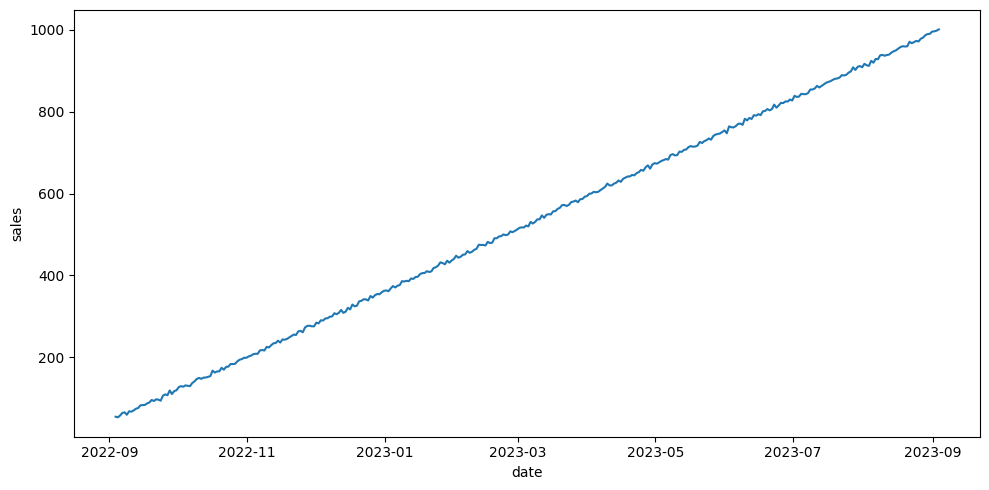

In [918]:
# Analizar la serie de tiempo en sales
ts = df["sales"].asfreq('D')
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
plt.tight_layout()
plt.show()

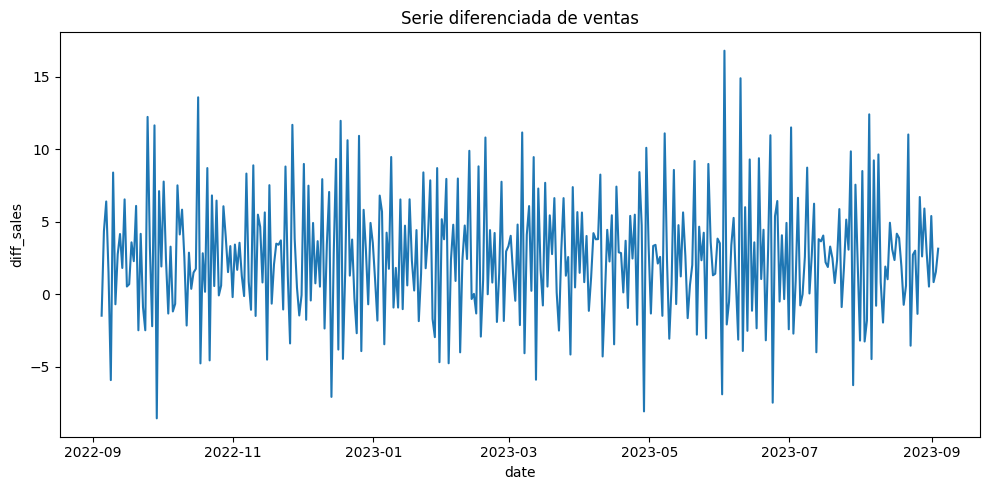

In [919]:
#Tranformacion del nuevo dataset
sales_dif = pd.read_csv("dataset_ventas.csv")
sales_dif["date"] = pd.to_datetime(sales_dif["date"])
sales_dif["year"] = sales_dif["date"].dt.year
sales_dif["month"] = sales_dif["date"].dt.month
sales_dif = sales_dif.set_index("date")
sales_dif = sales_dif.asfreq("D")

#Diferenciar
sales_dif["diff_sales"] = sales_dif["sales"].diff()
ts_dif = sales_dif["diff_sales"].dropna()
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=ts_dif)
plt.title("Serie diferenciada de ventas")
plt.tight_layout()
plt.show()


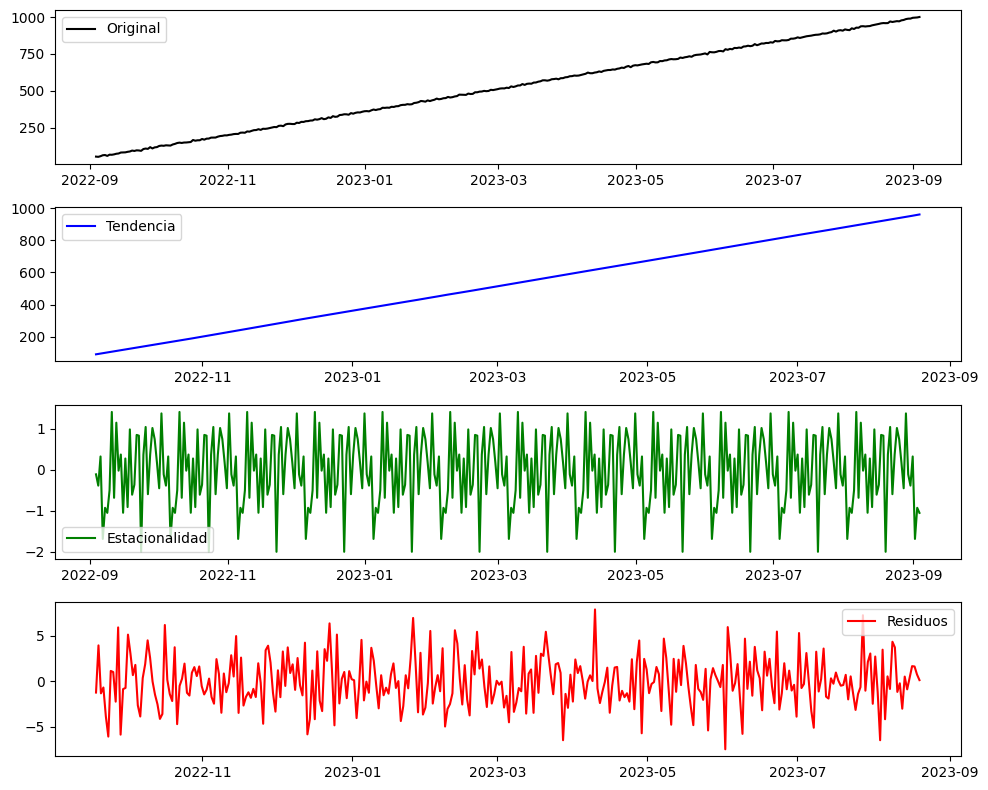

In [920]:
ts = ts.dropna()

#Visualizacion de la descomposicion
decomposition = seasonal_decompose(ts, period = 30)
decomposition
# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Grafica
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(ts, label="Original", color="black")
ax[0].legend()
ax[1].plot(trend, label="Tendencia", color="blue")
ax[1].legend()
ax[2].plot(seasonal, label="Estacionalidad", color="green")
ax[2].legend()
ax[3].plot(residual, label="Residuos", color="red")
ax[3].legend()
plt.tight_layout()
plt.show()


En los graficos podemos observar lo siguiente: En la tendencia (color azul), podemos ver un crecimiento lineal a lo largo del tiempo, es decir que las ventas aumentan con el pasar de los meses. 
Con relacion a la estacionalidad muesta un patron muy repetitivo, es decir que las ventas tienen variaciones periodicas cada ciertos meses. Y por ultimo, los residuos(color rojo), vemos que el comportamiento es un poco aleartorio, aunque se puede observar mucha estacionalidad. Par ello, buscaremos la manera de pobras otros modelos. 

In [921]:
#Comprobamos si la serie deferenciada ya se ajusta al modelo
resultado = adfuller(ts_dif)
print("p-valor:", resultado[1])


p-valor: 5.212954111417404e-16


Ahora vemos que la serie es estacionaria, ya que el valor es extremadamente bajo. 

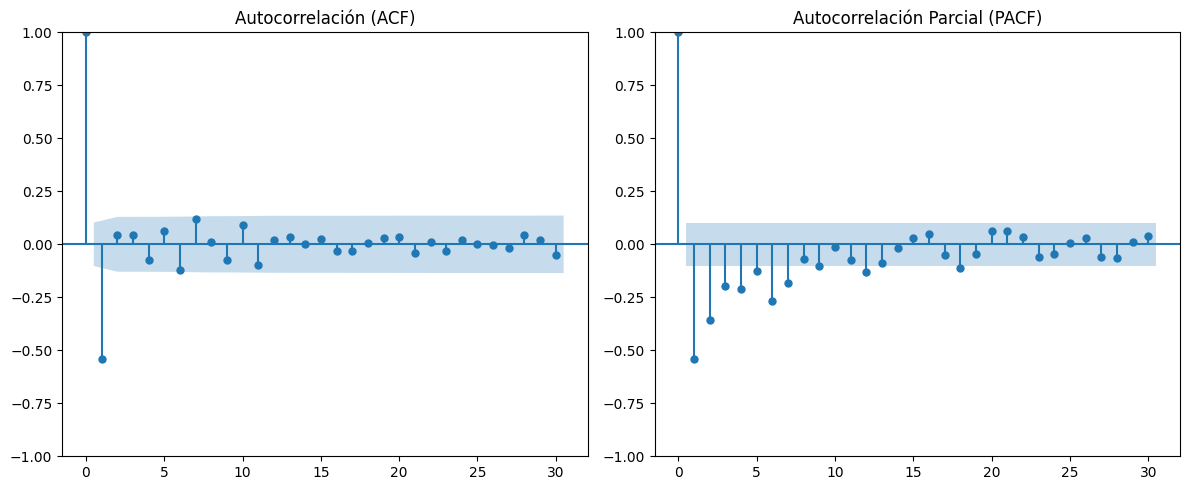

In [922]:
#Autocorrelacion y su Parcial
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ACF para determinar q
plot_acf(ts_dif, lags=30, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")
# PACF para determinar p
plot_pacf(ts_dif, lags=30, ax=ax[1], method="ywm")
ax[1].set_title("Autocorrelación Parcial (PACF)")
plt.tight_layout()
plt.show()

La grafica en ACF nos muestra los valores pasados con los nuevos, y podemos decir que la autocorrelacion cae muy rapido es decir que los valores antiguos no tienen qu ver con los valores actuales. Se observa que *q* al inicio tiene unos retardos significativos. 
La grafica de PACF es la relacion entre los retardos y el valor, podemos observar uno algunos picos en los primeros retardos, luego cae significativamente lo que se puede decir es que los primeros factores afectan la serie. 

Conclusion: como los valores en ACF Y PACF caen rapido entonces los valores en p y q podrian ser bajos.

In [923]:
ts_dif.index = pd.to_datetime(ts_dif.index)

In [924]:
#Divivir el entrenamiento
train_size = int(len(ts_dif) * 0.8)
train, test = ts_dif.iloc[:train_size], ts_dif.iloc[train_size:]
print(train.shape, test.shape)

(292,) (73,)


In [925]:
from pmdarima import auto_arima
model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
model

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1497.963, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1773.606, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1771.341, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1772.993, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1498.379, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1500.243, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1497.695, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1724.203, Time=0.05 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1742.891, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1720.940, Time=0.07 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept  

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

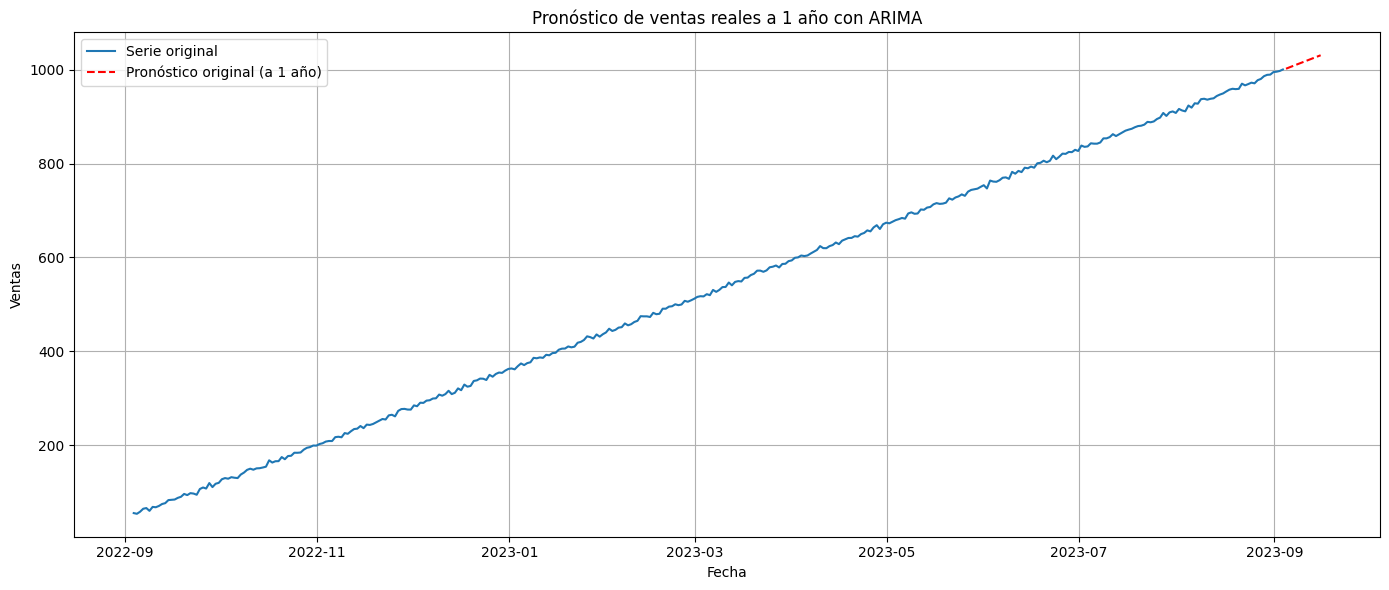

In [926]:
# Entrenamiento
modelo_arima = ARIMA(ts_dif, order=(1, 0, 3))
resultado_arima = modelo_arima.fit()

# Último valor real
last_real_value = ts.iloc[-1]

# Diferenciación acumulada y suma del último valor real
future_forecast = resultado_arima.forecast(steps=12)
forecast_original_scale = future_forecast.cumsum() + last_real_value

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(ts, label="Serie original")
plt.plot(forecast_original_scale, label="Pronóstico original (a 1 año)", color="red", linestyle="--")
plt.title("Pronóstico de ventas reales a 1 año con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico muestra un pronóstico de ventas basado del modelo ARIMA, comparando la serie original de ventas con una proyección a un año.

Al observar la serie original, se observa una tendencia en los datos, lo cual es clave para la modelización. La línea roja discontinua muestra el pronóstico desde 2023-10 hasta 2024-07, lo que sugiere que el modelo está prediciendo una continuidad en la tendencia con cierta variabilida

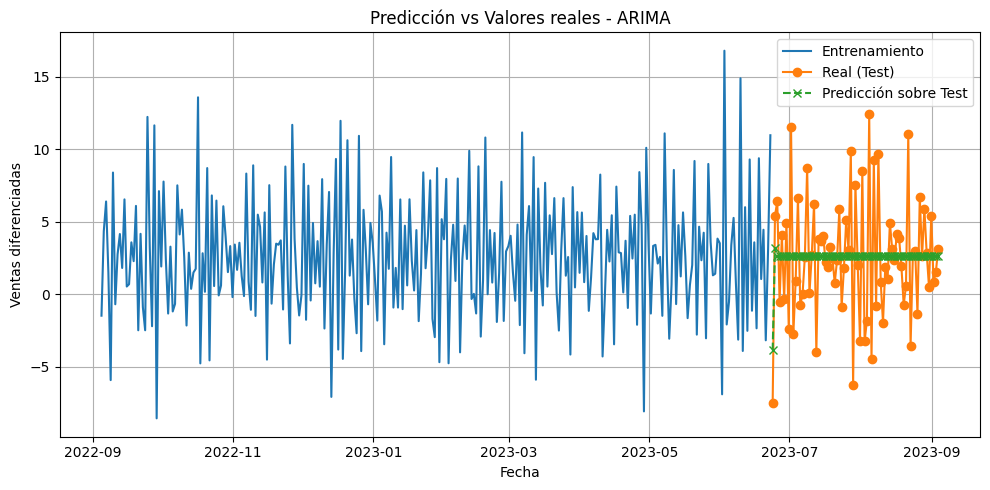

In [927]:
# Prediccion sobre el test
forecast = model.predict(n_periods=len(test))

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(train, label="Entrenamiento")
plt.plot(test.index, test, label="Real (Test)", marker="o")
plt.plot(test.index, forecast, label="Predicción sobre Test", linestyle="--", marker="x")
plt.title("Predicción vs Valores reales - ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas diferenciadas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

-  Color azul: La serie Entrenamiento, abarca desde septiembre de 2022 hasta mayo de 2023, es la que se usa para entrenar el modelo.
-  Color naranja: Los valores reales del test, corresponden a los datos desde mayo de 2023 hasta septiembre de 2023.
-  Color verde: La predicción sobre el test, intenta replicar la evolución de los valores reales dentro del mismo periodo.

Se puede apreciar que la prediccion sigue de cerca la tendencia de los valores reales lo que nos dice que el modelo sigue bien la estructura temporal de los datos. La serie de entrenamiento muestra una gran variabilidad en los valores, con fluctuaciones entre -5 y 15, es una alta volatibilidad que puede hacer que la prediccion sea mas desafiante.


Hay algunos picos negativos y positivos, lo que sugiere que en ciertos momentos el modelo sobreestima o subestima las predicciones.

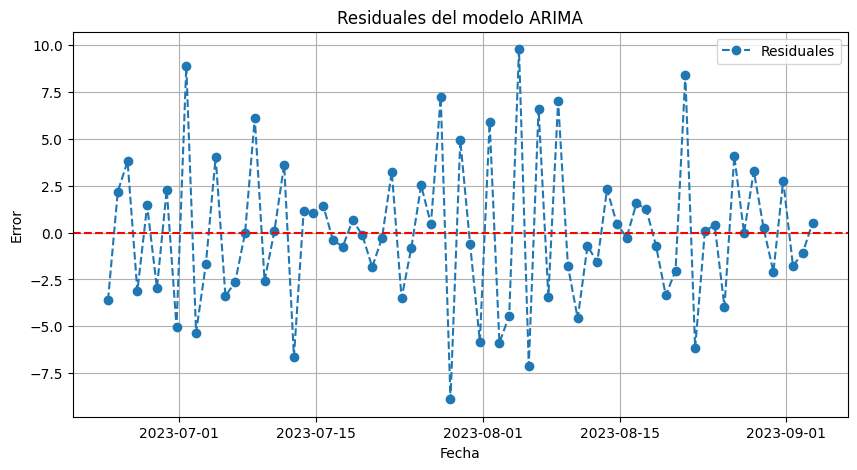

In [ ]:
# Diferencia entre valores reales y predicción
residuals = test - forecast

# Convertimos a DataFrame
residuals_df = pd.DataFrame(residuals, columns=["Residuales"])

# Grafica
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residuales", linestyle="--", marker="o")
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residuales del modelo ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()


In [929]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")


MAE: 3.03 | RMSE: 3.92


Conclusion: El modelo parece funcionar bien, con errores relativamente bajos y una fuerte significancia estadística.
El MAE indica que, en promedio, la predicción se desvía unos 3.03 unidades de los valores reales. Este error es relativamente bajo, lo que sugiere una buena precisión del modelo.